In [1]:
from __future__ import annotations

import fridom.shallowwater as sw
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------------------------------------------
#  Constants
# ----------------------------------------------------------------

RESOLUTION_FACTOR = 9
ROSSBY_NUMBER = 0.1  # advection scale

# ================================================================
#  Setup
# ================================================================

lx = ly = 2 * np.pi
nx = ny = 2**RESOLUTION_FACTOR - 1

# construct grid and modelsettings
grid = sw.grid.cartesian.Grid(N=(nx, ny), L=(lx, ly), periodic_bounds=(True, True))
mset = sw.ModelSettings(grid, f0=1.0, beta=0.0, csqr=1.0, Ro=ROSSBY_NUMBER).setup()

# ================================================================
#  Plot function
# ================================================================

def create_subplot(ax: plt.Axes,  #noqa: PLR0913
                   z: sw.State,
                   label: str,
                   title: str,
                   vmax: float,
                   max_vel: float,
                   cmap: str) -> None:
    """Create a subplot for the given state."""
    # create a plot of the pressure field
    im = z.p.xr.plot(ax=ax, cmap=cmap, vmin=-vmax, vmax=vmax, add_colorbar=False)

    # create a quiver plot of the velocity field
    skip = 2**(RESOLUTION_FACTOR - 5)
    m_vel = (z.u**2 + z.v**2).max().arr.item()**0.5
    q = (z.velocity/m_vel).xrs[::skip, ::skip].plot.quiver(
        "x", "y", "u", "v",
        ax=ax, color="black", scale=30 * max_vel / m_vel, headwidth=6, add_guide=False)

    ax.quiverkey(q, X=0.85, Y=1.08, U=1, label=f"${max_vel:.2g}$", labelpos="E",
                 fontproperties={"size": 13})

    # create a colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.1, shrink=0.8)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "0", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)


    ax.set_aspect("equal")
    ax.set_title(title, fontsize=18)
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(-0.2, 1.16, label, fontsize=20, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")

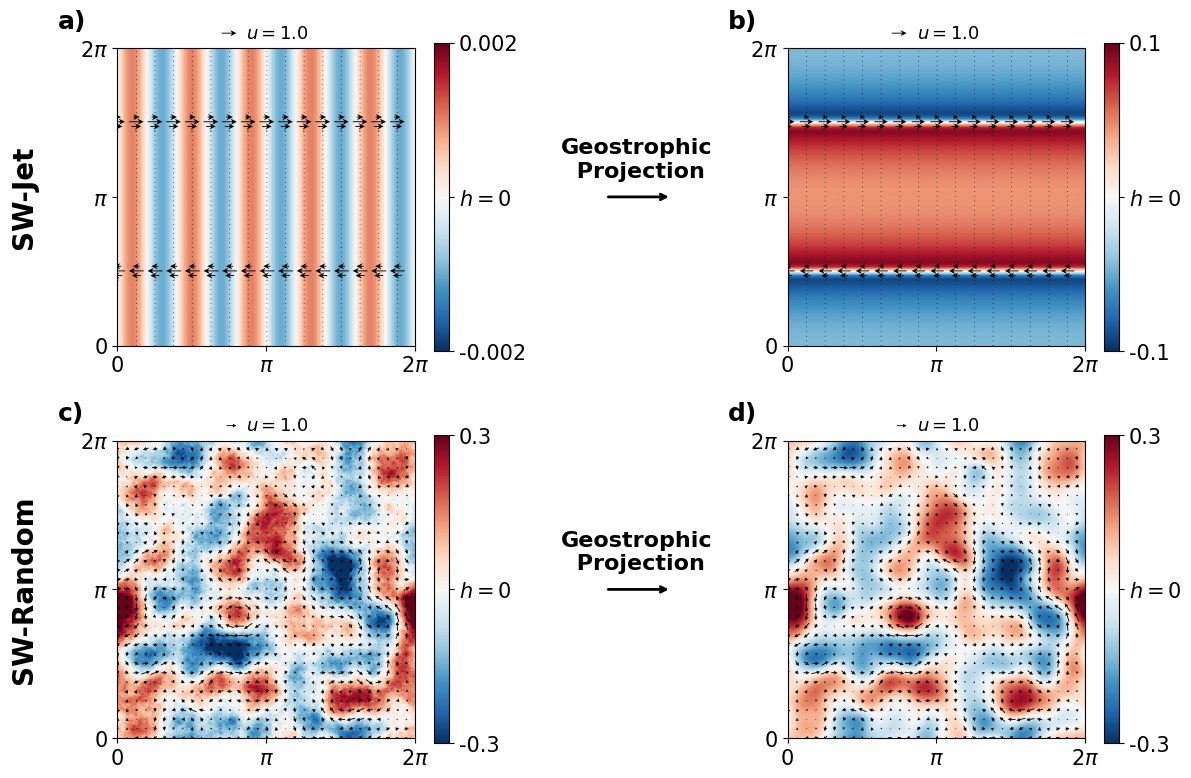

In [2]:
from matplotlib.gridspec import GridSpec

geo = sw.projection.GeostrophicSpectral(mset)

fig = plt.figure(figsize=(12, 8), tight_layout=True)

gs = GridSpec(nrows=2, ncols=3, figure=fig, width_ratios=[0.45, 0.1, 0.45])
axs = np.array([[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(2)])

# load the states
z_jet = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_ini.nc")
z_ran = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_ini.nc")
z_jet_geo = geo(z_jet)
z_ran_geo = geo(z_ran)


labels = iter(["a)", "b)", "c)", "d)", "e)", "f)"])

# first the jet state
for ax, vmax, z in zip([axs[0, 0], axs[0, 2]], [2e-3, 0.1], [z_jet, z_jet_geo]):
    im = z.p.xr.plot(ax=ax, vmax=vmax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "$h=0$", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)
    qi = z.xrs[::2**(RESOLUTION_FACTOR - 4), ::2**(RESOLUTION_FACTOR - 6)].plot.quiver(
        "x", "y", "u", "v", ax=ax, color="black", scale=20,
        add_guide=False, width=0.003, headwidth=7, headaxislength=5, headlength=7)
    ax.quiverkey(qi, X=0.4, Y=1.05, U=1, label=r"$u=1.0$", labelpos="E",
                 fontproperties={"size": 13})
    ax.text(-0.2, 1.13, next(labels), fontsize=18, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")


for ax, vmax, z in zip([axs[1, 0], axs[1, 2]], [0.3, 0.3], [z_ran, z_ran_geo]):
    im = z.p.xr.plot(ax=ax, vmax=0.3, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "$h=0$", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)
    qi = z.xrs[::2**(RESOLUTION_FACTOR - 5), ::2**(RESOLUTION_FACTOR - 5)].plot.quiver(
        "x", "y", "u", "v", ax=ax, color="black", scale=30,
        add_guide=False, width=0.003, headwidth=4, headaxislength=4, headlength=4)
    ax.quiverkey(qi, X=0.4, Y=1.05, U=1, label=r"$u=1.0$", labelpos="E",
                 fontproperties={"size": 13})
    ax.text(-0.2, 1.13, next(labels), fontsize=18, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")


for ax in axs.flatten():
    ax.set_aspect("equal")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")

for ax in axs[:, 1]:
    ax.axis("off")
    ax.text(3, 6, "Geostrophic\n Projection", ha="center", va="center",
            fontsize=16, fontweight="bold")
    ax.annotate("", xy=(0.9, 0.5), xytext=(0.1, 0.5),
                arrowprops={"arrowstyle":"->", "lw":2},
                xycoords="axes fraction")

# Row titles
row_titles = ["SW-Jet", "SW-Random"]
for ax, row in zip(axs[:,0], row_titles):
    # Use y-label position to place row title
    ax.set_ylabel(row, fontsize=20, labelpad=40, va="center", fontweight="bold")

plt.savefig("../figures/shallow_water_configurations.png", dpi=200, bbox_inches="tight")

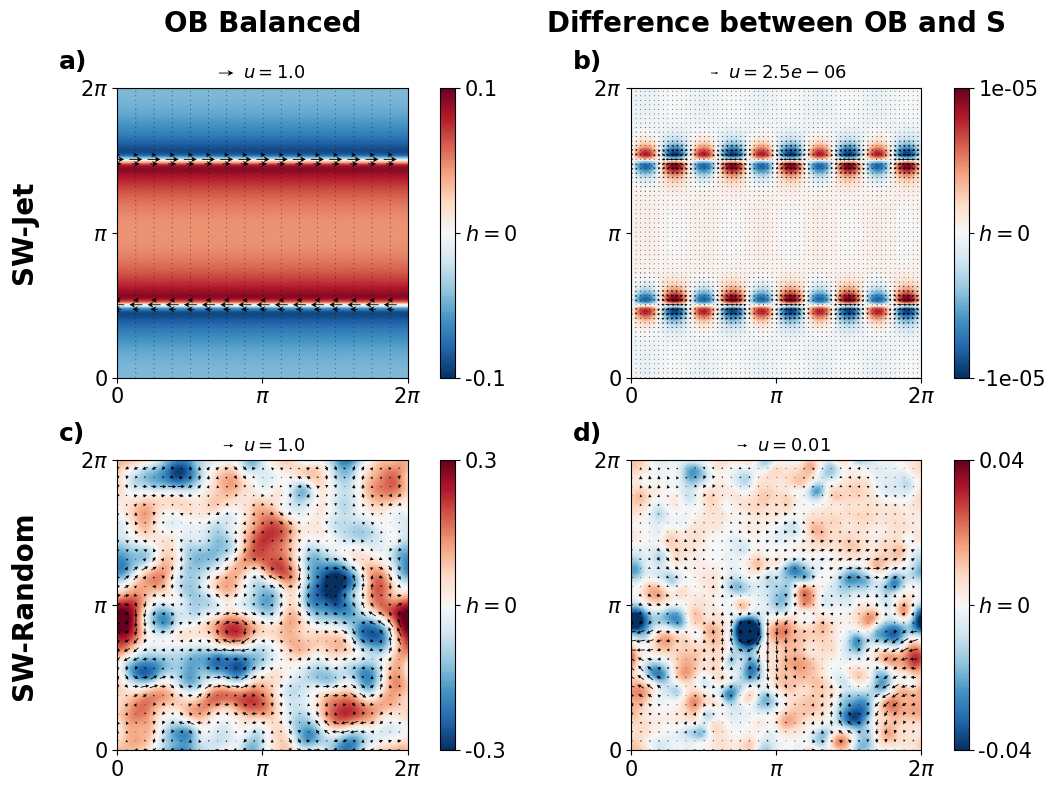

In [3]:
z_jet_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_ini_bal.nc")
z_ran_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_ini_bal.nc")
z_jet_sla = z_jet_bal - z_jet_geo
z_ran_sla = z_ran_bal - z_ran_geo

fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)
labels = iter(["a)", "b)", "c)", "d)", "e)", "f)"])

for ax, vmax, z in zip([axs[0, 0], axs[0, 1]], [0.1, 1e-5], [z_jet_bal, z_jet_sla]):
    im = z.p.xr.plot(ax=ax, vmax=vmax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "$h=0$", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)
    ax.text(-0.2, 1.13, next(labels), fontsize=18, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")

umax = 1.0
qi = z_jet_bal.xrs[::2**(RESOLUTION_FACTOR - 4), ::2**(RESOLUTION_FACTOR - 6)].plot.quiver(
    "x", "y", "u", "v", ax=axs[0,0], color="black", scale=20,
    add_guide=False, width=0.003, headwidth=7, headaxislength=5, headlength=7)
axs[0,0].quiverkey(qi, X=0.4, Y=1.05, U=umax, label=r"$u=1.0$", labelpos="E",
                fontproperties={"size": 13})

umax = 5e-6
qi = z_jet_sla.xrs[::2**(RESOLUTION_FACTOR - 6), ::2**(RESOLUTION_FACTOR - 6)].plot.quiver(
    "x", "y", "u", "v", ax=axs[0,1], color="black", scale=20*umax,
    add_guide=False, width=0.003, headwidth=3, headaxislength=3, headlength=3)
axs[0,1].quiverkey(qi, X=0.3, Y=1.05, U=umax/2, label=f"$u={umax/2}$", labelpos="E",
                fontproperties={"size": 13})

for ax, vmax, z, umax, umax_label in zip([axs[1, 0], axs[1, 1]],
                             [0.3, 0.04],
                             [z_ran_bal, z_ran_sla],
                             [1.0, 0.01],
                             [r"$u=1.0$", r"$u=0.01$"]):
    im = z.p.xr.plot(ax=ax, vmax=vmax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "$h=0$", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)
    qi = z.xrs[::2**(RESOLUTION_FACTOR - 5), ::2**(RESOLUTION_FACTOR - 5)].plot.quiver(
        "x", "y", "u", "v", ax=ax, color="black", scale=30*umax,
        add_guide=False, width=0.003, headwidth=4, headaxislength=4, headlength=4)
    ax.quiverkey(qi, X=0.4, Y=1.05, U=1*umax, label=umax_label, labelpos="E",
                 fontproperties={"size": 13})
    ax.text(-0.2, 1.13, next(labels), fontsize=18, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")

for ax in axs.flatten():
    ax.set_aspect("equal")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")


# Row titles
row_titles = ["SW-Jet", "SW-Random"]
for ax, row in zip(axs[:,0], row_titles):
    # Use y-label position to place row title
    ax.set_ylabel(row, fontsize=20, labelpad=40, va="center", fontweight="bold")

# Column titles
col_titles = ["OB Balanced", "Difference between OB and $\\mathbf{S}$"]
for ax, col in zip(axs[0,:], col_titles):
    # Use x-label position to place column title
    ax.set_title(col, fontsize=20, fontweight="bold", pad=40)

plt.savefig("../figures/shallow_water_balanced.png", dpi=200, bbox_inches="tight")

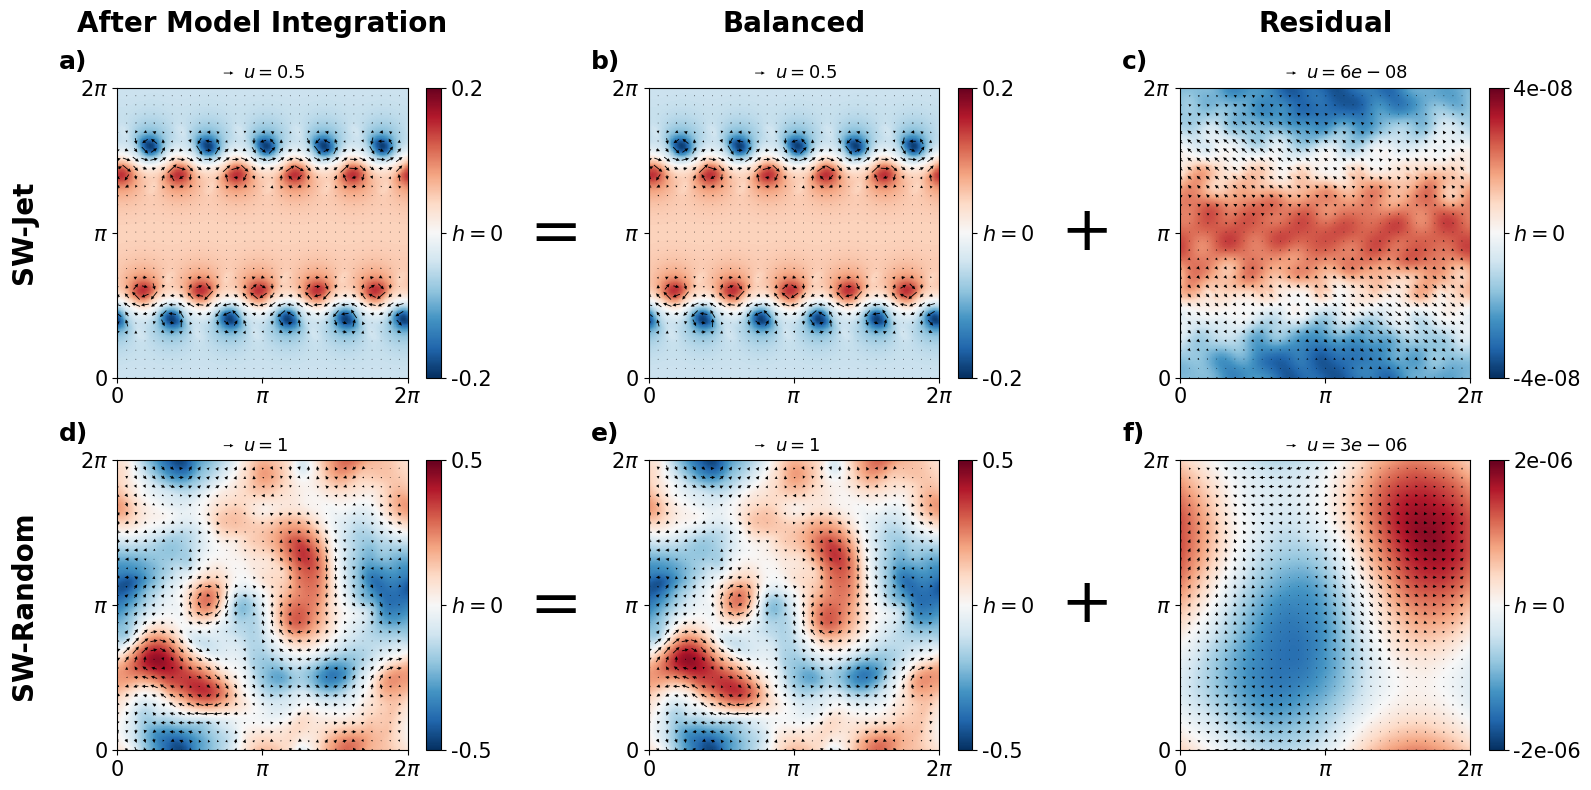

In [260]:
z_jet_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_evo.nc")
z_ran_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_evo.nc")
z_jet_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_evo_bal.nc")
z_ran_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_evo_bal.nc")
z_jet_res = z_jet_evo - z_jet_evo_bal
z_ran_res = z_ran_evo - z_ran_evo_bal

fig, axs = plt.subplots(2, 3, figsize=(16, 8), tight_layout=True)
labels = iter(["a)", "b)", "c)", "d)", "e)", "f)"])

for ax, z, vmax, umax in zip(axs.flatten(), [z_jet_evo, z_jet_evo_bal, z_jet_res,
                                 z_ran_evo, z_ran_evo_bal, z_ran_res],
                                 [0.2, 0.2, 4e-8, 0.5, 0.5, 2e-6],
                                 [0.5, 0.5, 6e-8, 1.0, 1.0, 3e-6]):
    im = z.p.xr.plot(ax=ax, cmap="RdBu_r", vmin=-vmax, vmax=vmax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "$h=0$", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)

    qi = z.xrs[::2**(RESOLUTION_FACTOR - 5), ::2**(RESOLUTION_FACTOR - 5)].plot.quiver(
        "x", "y", "u", "v", ax=ax, color="black", scale=30*umax,
        add_guide=False, width=0.003, headwidth=4, headaxislength=4, headlength=4)
    ax.quiverkey(qi, X=0.4, Y=1.05, U=1*umax, label=f"$u={umax:.2g}$", labelpos="E",
                 fontproperties={"size": 13})

    ax.text(-0.2, 1.13, next(labels), fontsize=18, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")

    ax.set_aspect("equal")
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")


# Row titles
row_titles = ["SW-Jet", "SW-Random"]
for ax, row in zip(axs[:,0], row_titles):
    # Use y-label position to place row title
    ax.set_ylabel(row, fontsize=20, labelpad=40, va="center", fontweight="bold")

# Column titles
col_titles = ["After Model Integration", "Balanced", "Residual"]
for ax, col in zip(axs[0,:], col_titles):
    # Use x-label position to place column title
    ax.set_title(col, fontsize=20, fontweight="bold", pad=40)

for ax in axs[:, 1]:
    ax.text(-0.35, 0.5, "$=$", fontsize=45, fontweight="bold",
         transform=ax.transAxes, va="center", ha="center")
    ax.text(1.5, 0.5, "$+$", fontsize=45, fontweight="bold",
         transform=ax.transAxes, va="center", ha="center")

plt.savefig("../figures/shallow_water_evolution.png", dpi=200, bbox_inches="tight")

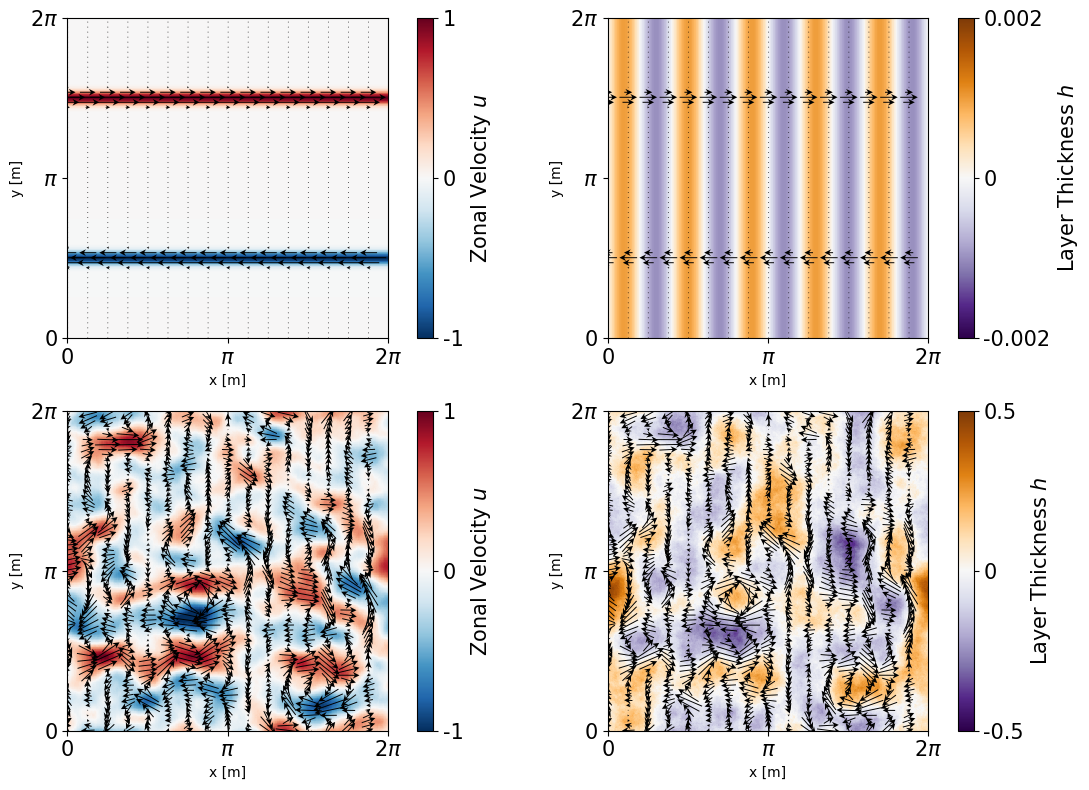

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# load the states
z_jet = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_ini.nc")
z_ran = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_ini.nc")

vmaxs = [[1.0, 2e-3], [1.0, 0.5]]  # max values for u and h

titles = ["SW Jet", "SW Random"]
fields = {"u": lambda z: z.u, "h": lambda z: z.p}
cmaps = {"u": "RdBu_r", "h": "PuOr_r"}
colorbar_labels = {"u": "Zonal Velocity $u$", "h": "Layer Thickness $h$"}

for axes, z, vmaxes, title in zip(axs, [z_jet, z_ran], vmaxs, titles):
    for ax, fname, vmax in zip(axes, ["u", "h"], vmaxes):
        f = fields[fname](z)
        label = f"{fname.upper()}"
        cmap = cmaps[fname]
        im = f.xr.plot(ax=ax, cmap=cmap, vmin=-vmax, vmax=vmax, add_colorbar=False)

        # create a colorbar
        cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.05, shrink=1.0)
        cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "0", f"{vmax:.2g}"])
        cbar.ax.tick_params(labelsize=15)
        cbar.set_label(colorbar_labels[fname], fontsize=15)


        ax.set_aspect("equal")
        ax.set_title(title, fontsize=18, fontweight="bold")
        ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
        ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
        ax.set_xlabel("")
        ax.set_ylabel("")

        zx = z.xrs[::2**(RESOLUTION_FACTOR - 6), ::2**(RESOLUTION_FACTOR - 6)]
        angles = np.arctan2(zx.v.values, zx.u.values) * 180 / np.pi
        amplitudes = (zx.u**2 + zx.v**2).values**0.5

        # for i, x in enumerate(zx.x.values):
        #     for j, y in enumerate(zx.y.values):
        #         v = zx.u[i, j].values
        #         u = zx.v[i, j].values
        #         amp = amplitudes[i, j]
        #         angle = angles[i, j]
        #         ax.scatter(
        #             y, x,
        #             s=(amp / np.max(amplitudes)) * 7,  # scale size
        #             marker=(3, 0, angle),  # marker with angle
        #             color='k',  # color of the marker
        #         )

        # break

        # select every 2**(RESOLUTION_FACTOR - 5) points for the quiver plot
        z.xr.isel(
            x=slice(None, None, 2**(RESOLUTION_FACTOR - 4)),
            y=slice(None, None, 2**(RESOLUTION_FACTOR - 6))
        ).plot.quiver(
            "x", "y", "u", "v",
            ax=ax, color="black", scale=9 * vmax / f.xr.max().item(),
            add_guide=False,
            width=0.003,            # make shaft very thin
            headwidth=7,            # make head wide
            headaxislength=5,       # stretch head
            headlength=7,
            # pivot='middle',
            edgecolor='k',
            facecolor='k',
        )

        # contours in black
        # z.p.xr.plot.contour(ax=ax, colors="black", linewidths=1.0, levels=4)
        # ax.text(-0.2, 1.16, label, fontsize=20, fontweight="bold",
        #         transform=ax.transAxes, va="top", ha="left")

# def create_subplot(ax: plt.Axes,  #noqa: PLR0913
#                    f: sw.ScalarField,
#                    label: str,
#                    title: str,
#                    vmax: float,
#                    cmap: str) -> None:
#     """Create a subplot for the given state."""
#     # create a plot of the pressure field

# create_subplot(axs[0, 0], z_jet.u, "a)", "SW-Jet: u", 1.0, "RdBu_r")
# create_subplot(axs[0, 1], z_jet.p, "b)", "SW-Jet: h", 1e-3, "RdBu_r")

# create_subplot(axs[1, 0], z_ran.u, "c)", "SW-Random: u", 1.0, "RdBu_r")
# create_subplot(axs[1, 1], z_ran.p, "d)", "h", 0.5, "RdBu_r")

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

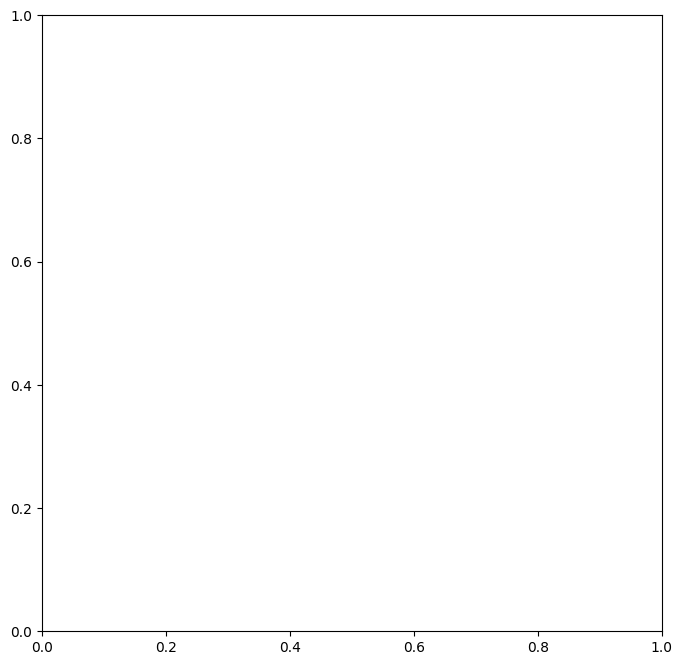

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Arrow direction encoded in angle, size scaled by magnitude
u = np.random.rand(x.shape[0], x.shape[1])  # random u component
v = np.random.rand(x.shape[0], x.shape[1])  # random v

amplitude = np.sqrt(u**2 + v**2)
angles = np.arctan2(v, u) * 180 / np.pi
# create an array with shape (n, 3) for markers
markers = np.array([3, 0, angles.flatten()])  # triangle marker

ax.scatter(
    x.flatten(), y.flatten(),
    marker=markers,
    s=amplitude.flatten() * 100,  # scale size for visibility
    color='k'
)

# amplitude.flatten().shape


In [27]:
angles

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

# Jet initial Condition

TypeError: create_subplot() takes 6 positional arguments but 7 were given

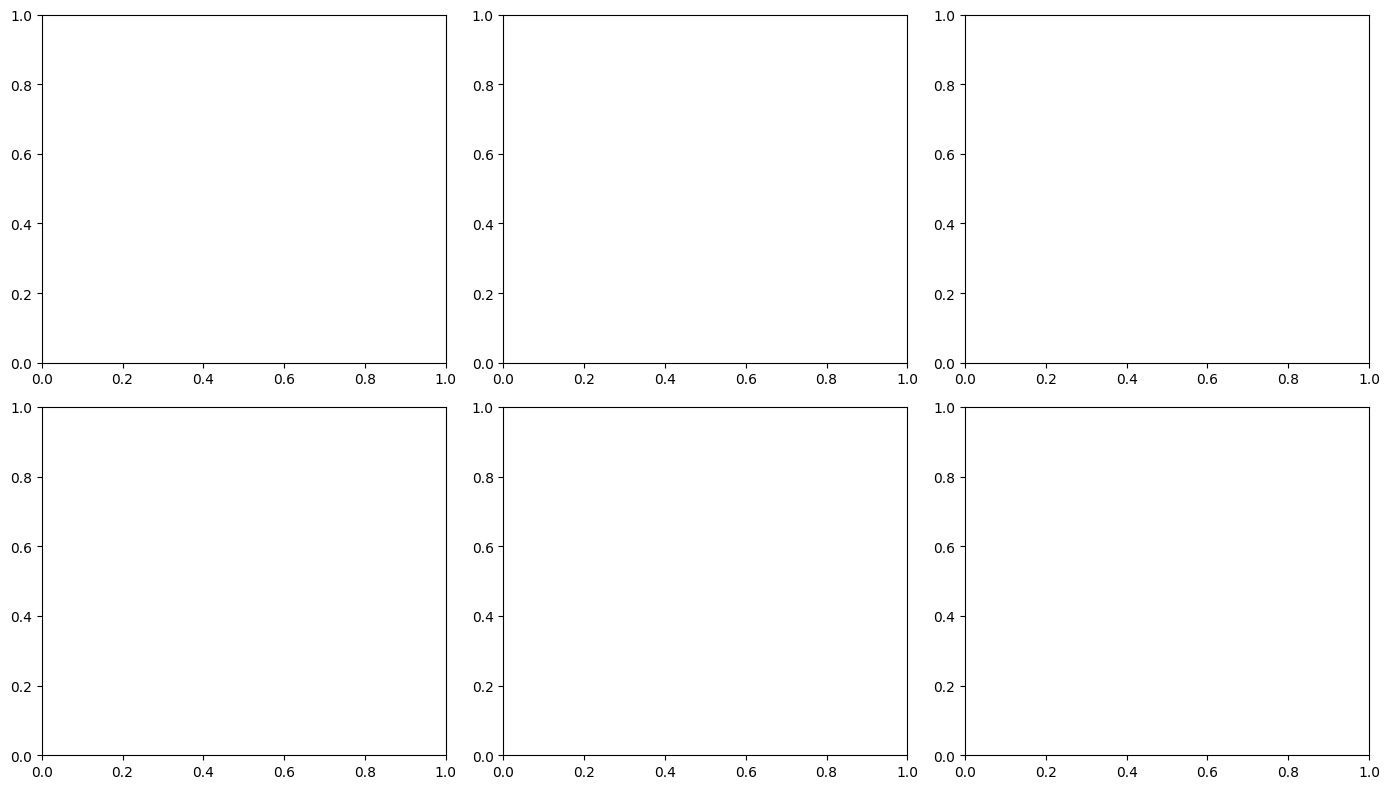

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)

# load the states
z_ini = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_ini.nc")
z_ini_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_ini_bal.nc")
z_ini_res = z_ini - z_ini_bal

z_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_evo.nc")
z_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_jet/z_evo_bal.nc")
z_evo_res = z_evo - z_evo_bal

create_subplot(axs[0, 0], z_ini, "a)", "Full", 1e-3, 1.0, "PuOr_r")
create_subplot(axs[0, 1], z_ini_bal, "b)", "Balanced", 0.1, 1.0, "RdBu_r")
create_subplot(axs[0, 2], z_ini_res, "c)", "Residual", 0.1, 0.1, "RdBu_r")
create_subplot(axs[1, 0], z_evo, "d)", "Full", 0.15, 0.5, "RdBu_r")
create_subplot(axs[1, 1], z_evo_bal, "e)", "Balanced", 0.15, 0.5, "RdBu_r")
create_subplot(axs[1, 2], z_evo_res, "f)", "Residual", 4e-8, 4e-8, "PuOr_r")

plt.savefig("../figures/example_jet_sw.png", dpi=200)

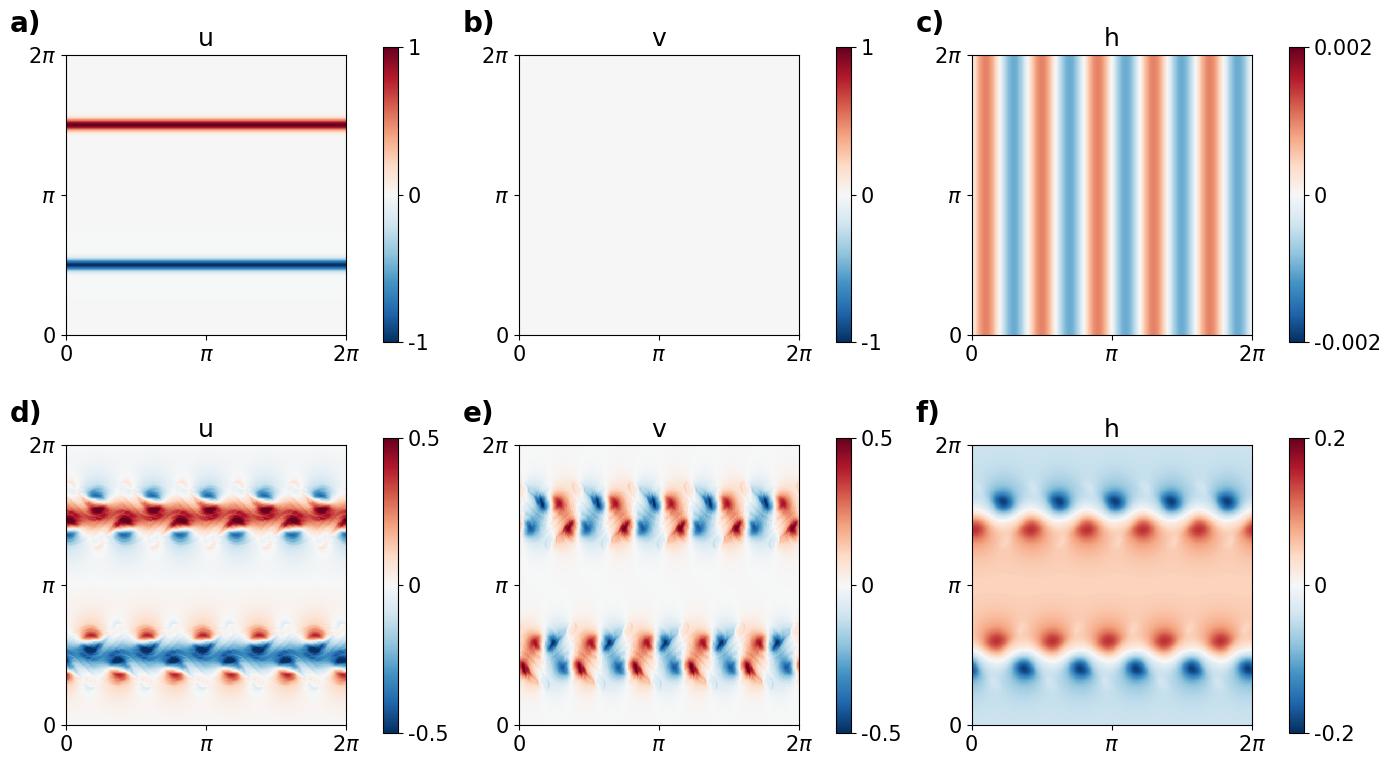

In [28]:
def create_subplot(ax: plt.Axes,  #noqa: PLR0913
                   f: sw.ScalarField,
                   label: str,
                   title: str,
                   vmax: float,
                   cmap: str) -> None:
    """Create a subplot for the given state."""
    # create a plot of the pressure field
    im = f.xr.plot(ax=ax, cmap=cmap, vmin=-vmax, vmax=vmax, add_colorbar=False)

    # create a colorbar
    cbar = plt.colorbar(im, ax=ax, orientation="vertical", pad=0.1, shrink=0.8)
    cbar.set_ticks([-vmax, 0, vmax], labels=[f"{-vmax:.2g}", "0", f"{vmax:.2g}"])
    cbar.ax.tick_params(labelsize=15)


    ax.set_aspect("equal")
    ax.set_title(title, fontsize=18)
    ax.set_xticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_yticks([0, np.pi, 2*np.pi], ["0", r"$\pi$", r"$2\pi$"], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.text(-0.2, 1.16, label, fontsize=20, fontweight="bold",
            transform=ax.transAxes, va="top", ha="left")

fig, axs = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)

create_subplot(axs[0, 0], z_ini.u, "a)", "u", 1.0, "RdBu_r")
create_subplot(axs[0, 1], z_ini.v, "b)", "v", 1.0, "RdBu_r")
create_subplot(axs[0, 2], z_ini.p, "c)", "h", 2e-3, "RdBu_r")

create_subplot(axs[1, 0], z_evo.u, "d)", "u", 0.5, "RdBu_r")
create_subplot(axs[1, 1], z_evo.v, "e)", "v", 0.5, "RdBu_r")
create_subplot(axs[1, 2], z_evo.p, "f)", "h", 0.2, "RdBu_r")

# Random

TypeError: create_subplot() takes 6 positional arguments but 7 were given

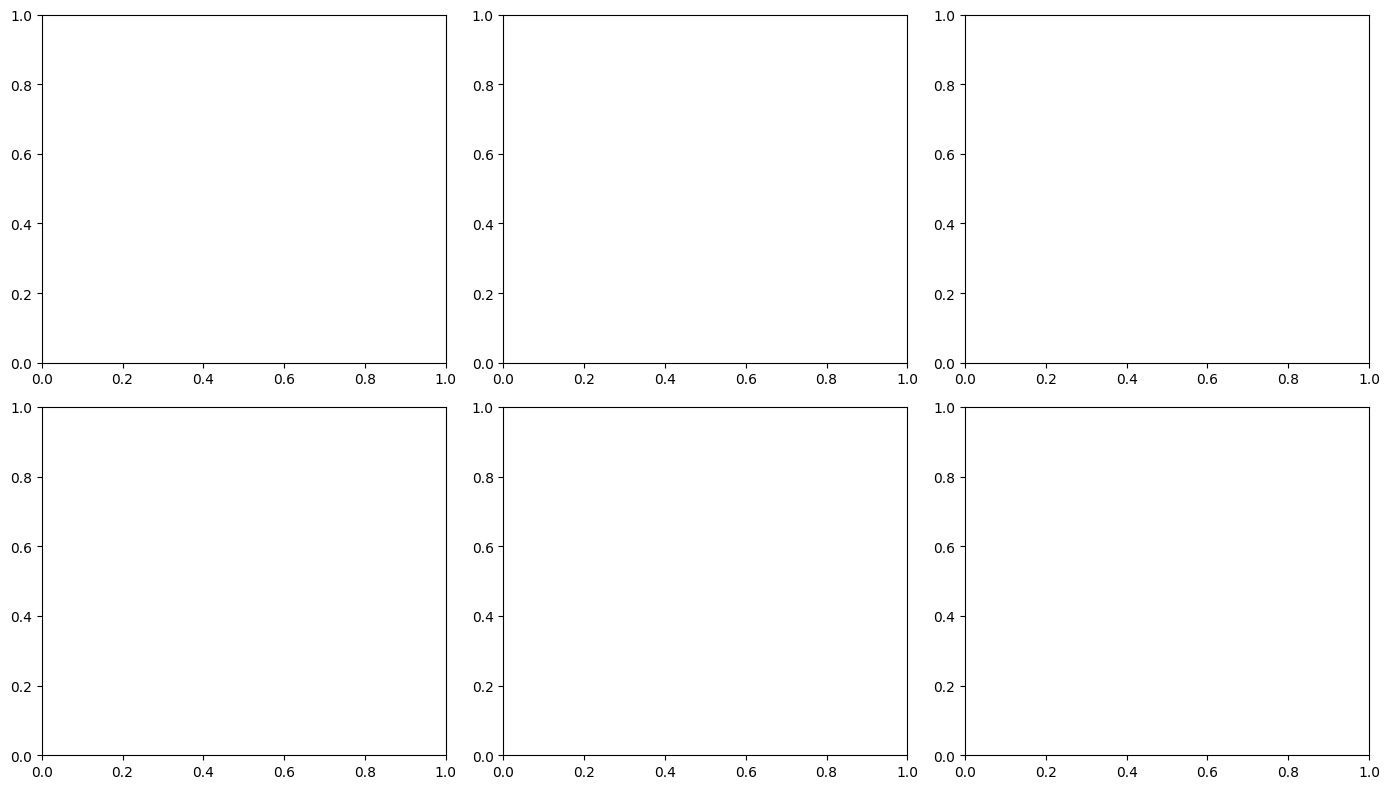

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)

# load the states
z_ini = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_ini.nc")
z_ini_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_ini_bal.nc")
z_ini_res = z_ini - z_ini_bal

z_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_evo.nc")
z_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random/z_evo_bal.nc")
z_evo_res = z_evo - z_evo_bal

create_subplot(axs[0, 0], z_ini, "a)", "Full", 0.3, 1.0, "RdBu_r")
create_subplot(axs[0, 1], z_ini_bal, "b)", "Balanced", 0.3, 1.0, "RdBu_r")
create_subplot(axs[0, 2], z_ini_res, "c)", "Residual", 0.3, 0.2, "RdBu_r")
create_subplot(axs[1, 0], z_evo, "d)", "Full", 0.4, 1.0, "RdBu_r")
create_subplot(axs[1, 1], z_evo_bal, "e)", "Balanced", 0.4, 1.0, "RdBu_r")
create_subplot(axs[1, 2], z_evo_res, "f)", "Residual", 2e-6, 3e-6, "PuOr_r")

plt.savefig("../figures/example_random_sw.png", dpi=200)

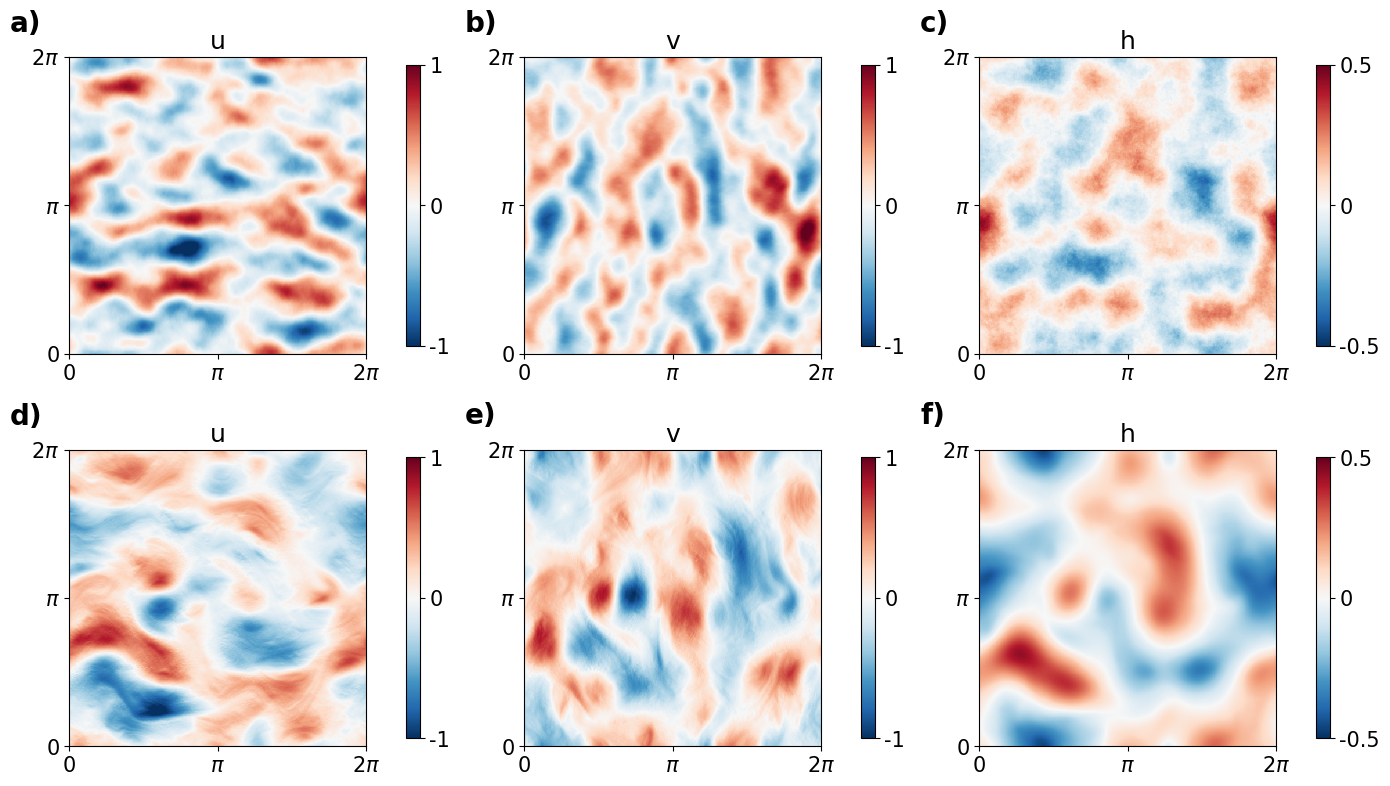

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)

create_subplot(axs[0, 0], z_ini.u, "a)", "u", 1.0, "RdBu_r")
create_subplot(axs[0, 1], z_ini.v, "b)", "v", 1.0, "RdBu_r")
create_subplot(axs[0, 2], z_ini.p, "c)", "h", 0.5, "RdBu_r")

create_subplot(axs[1, 0], z_evo.u, "d)", "u", 1.0, "RdBu_r")
create_subplot(axs[1, 1], z_evo.v, "e)", "v", 1.0, "RdBu_r")
create_subplot(axs[1, 2], z_evo.p, "f)", "h", 0.5, "RdBu_r")

# Random with Boundaries

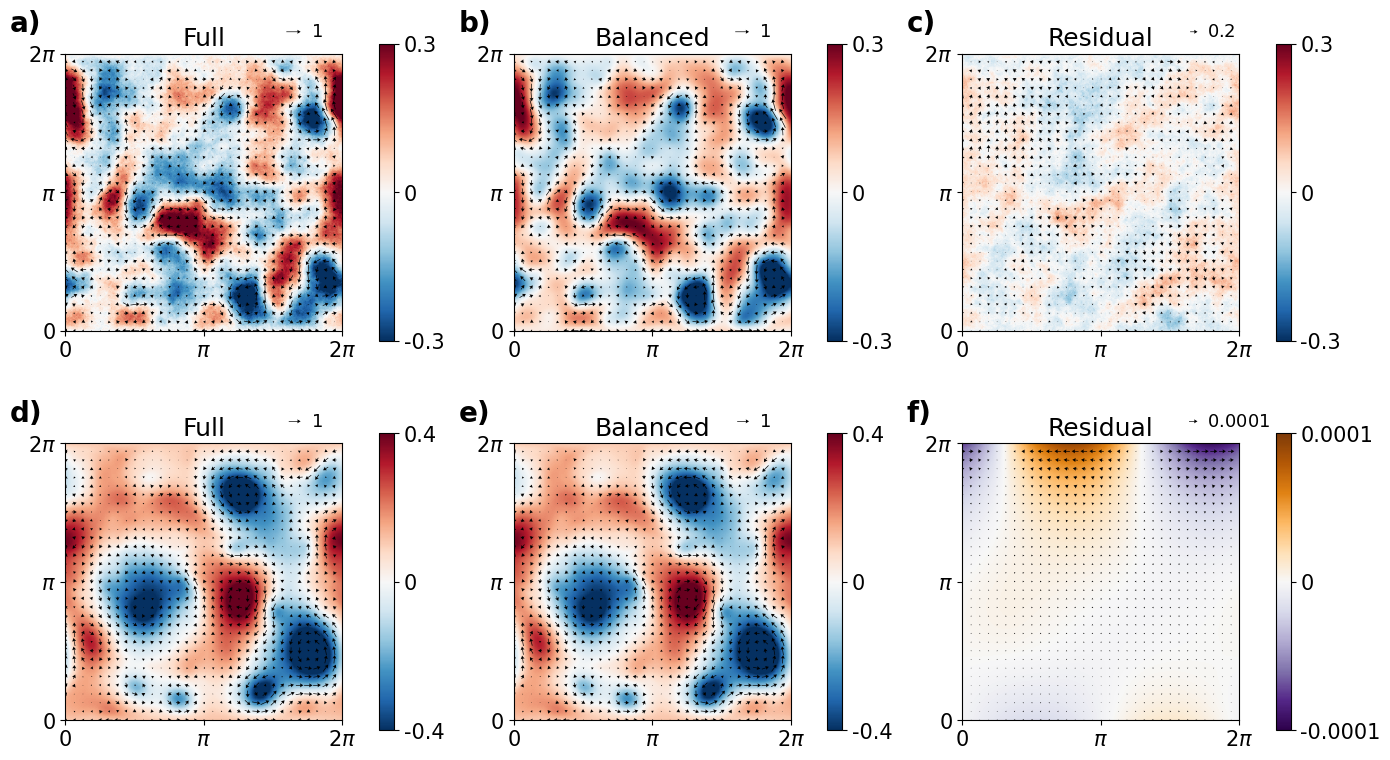

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)

# load the states
z_ini = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_ini.nc")
z_ini_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_ini_bal.nc")
z_ini_res = z_ini - z_ini_bal

z_evo = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_evo.nc")
z_evo_bal = sw.State.from_netcdf(mset, "../data/examples/shallow_water_random_bound/z_evo_bal.nc")
z_evo_res = z_evo - z_evo_bal

create_subplot(axs[0, 0], z_ini, "a)", "Full", 0.3, 1.0, "RdBu_r")
create_subplot(axs[0, 1], z_ini_bal, "b)", "Balanced", 0.3, 1.0, "RdBu_r")
create_subplot(axs[0, 2], z_ini_res, "c)", "Residual", 0.3, 0.2, "RdBu_r")
create_subplot(axs[1, 0], z_evo, "d)", "Full", 0.4, 1.0, "RdBu_r")
create_subplot(axs[1, 1], z_evo_bal, "e)", "Balanced", 0.4, 1.0, "RdBu_r")
create_subplot(axs[1, 2], z_evo_res, "f)", "Residual", 1e-4, 1e-4, "PuOr_r")

# plt.savefig("../figures/example_random_sw.png", dpi=200)